**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../..')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import build_newshapes_config, build_coco_config
from mrcnn.coco            import prep_coco_dataset, CocoConfig ## CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences
from mrcnn.utils import convertHtmlToPdf

# Device to load the neural network on Useful if you're training a model on the same 
# machine, in which case use CPU and leave the GPU for training.
DEVICE = "/cpu:1"  # /cpu:0 or /gpu:0

Using TensorFlow backend.


In [2]:
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
input_parms = " --epochs 2 " 
input_parms +=" --steps_in_epoch  10 "    
input_parms +=" --val_steps        5 " 
input_parms +=" --last_epoch       0 "
input_parms +=" --batch_size       1 "
input_parms +=" --lr          0.0001 "
input_parms +=" --mrcnn_logs_dir train_mrcnn_newshapes "
input_parms +=" --fcn_logs_dir   train_fcn8_l2_newshapes "
# input_parms +=" --fcn_logs_dir   train_fcn32_newshapes "
input_parms +=" --mrcnn_model    last "
input_parms +=" --fcn_model      init "
input_parms +=" --opt            adam "
input_parms +=" --fcn_arch       fcn8L2 " 
input_parms +=" --fcn_layers     all " 
input_parms +=" --sysout         screen "
input_parms +=" --scale_factor     1 " 
input_parms +=" --new_log_folder   "        

parser = utils.command_line_parser()
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)
## Configurations


   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8_l2_newshapes
   fcn_losses                     fcn_BCE_loss
   fcn_model                      init
   last_epoch                     0
   lr                             0.0001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    last
   new_log_folder                 True
   opt                            ADAM
   scale_factor                   1
   steps_in_epoch                 10
   sysout                         SCREEN
   val_steps                      5




In [3]:
fcn_config = build_newshapes_config( model = 'fcn', mode = 'inference', args = args)

>>> Initialize Paths
 windows  Windows


In [4]:
## Build FCN Model
with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN8L2', config=fcn_config)

fcn_model.keras_model.summary()

>>> Initialize ModelBase model 
   Mode      :  inference
   Model dir :  F:\models_newshapes\train_fcn8_l2_newshapes
>>> ModelBase initialiation complete
>>> Initialize FCN model, mode:  inference architecture:  FCN8L2
    arch set to FCN8 - with L2 Regularization
<function fcn8_l2_graph at 0x000000C0336D8C80>


---------------------------------------------------
 Build FCN Model -  Arch:  FCN8L2  mode:  inference
---------------------------------------------------

------------------------------------------------------
>>> FCN8L2 Layer With Regularization - mode: inference
------------------------------------------------------
     feature map      : (?, 128, 128, 7)
     height : 128 width : 128 classes : 7
     image_data_format:  channels_last
     rois_per_class   :  channels_last
     FCN L2 weight decay :  0.0001
     Set learning phase to : 0
   Input feature map                   :  (?, 128, 128, 7)
   FCN Block 11 shape is               :  (None, 128, 128, 64)
   FCN Block 1

    old_style_scores               :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1_scattered         :  shape: (1, 7, 64, 3)         KB.shape:(1, 7, 64, 3)         Keras Tensor: False
    alt_scores_1_norm(by_class)    :  shape: (1, 7, 64, 3)         KB.shape:(1, 7, 64, 3)         Keras Tensor: False
    alt_scores_1_norm(by_image)    :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False

    Normalize heatmap within each class !-------------------------------------
    in_heatmap_norm :  (?, 7, 128, 128) Keras tensor  False
    normalizer shape   :  (?, 7, 1, 1)
    normalized heatmap :  (?, 7, 128, 128)  Keras tensor  False
    hm_indices shape               :  shape: (?, 2)                KB.shape:(None, 2)             Keras Tensor: False
    pt2_heatmaps                   :  shape: (?, 

## Set weight files

In [5]:
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn_coco/fcn20181023T0825'
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181026T1432'
# DIR_WEIGHTS =  'F:/models/train_fcn8_bce/fcn20181205T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization

DIR_WEIGHTS =  'F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization

# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
# files   = ['fcn_0104.h5','fcn_0150.h5','fcn_0205.h5','fcn_0249.h5','fcn_0293.h5','fcn_0346.h5','fcn_0419.h5']
files   = ['fcn_0001.h5', 'fcn_0150.h5', 'fcn_0346.h5', 'fcn_0421.h5',
           'fcn_0450.h5', 'fcn_0482.h5', 'fcn_0521.h5', 'fcn_0610.h5',
           'fcn_0687.h5', 'fcn_0793.h5', 'fcn_0821.h5', 'fcn_0940.h5',
           'fcn_1012.h5', 'fcn_1127.h5', 'fcn_1644.h5', 'fcn_1776.h5',
           'fcn_1848.h5', 'fcn_2017.h5', 'fcn_2084.h5', 'fcn_x0434.h5', 'fcn_x0419.h5']

## Load Weights - 1

In [6]:
FILE_IDX = 10

weights_path = os.path.join(DIR_WEIGHTS  , files[FILE_IDX])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0821.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0821.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0821.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0821.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [7]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[FILE_IDX]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 7, 64)",-0.1208454669,+0.1121485904,+0.0533254631
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0238829367,+0.0209746994,+0.0081720892
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0921005830,+0.0912629589,+0.0386416316
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0185335446,+0.0096117891,+0.0070459563
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0733317658,+0.0917172134,+0.0300087277
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0156416334,+0.0195270926,+0.0057857595
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0715069845,+0.0736423582,+0.0246193744
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0182602890,+0.0152485790,+0.0065080440
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0704595000,+0.0731557608,+0.0202737618
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0185534917,+0.0262467433,+0.0087567689


### Histograms of Weights - 1st weight file

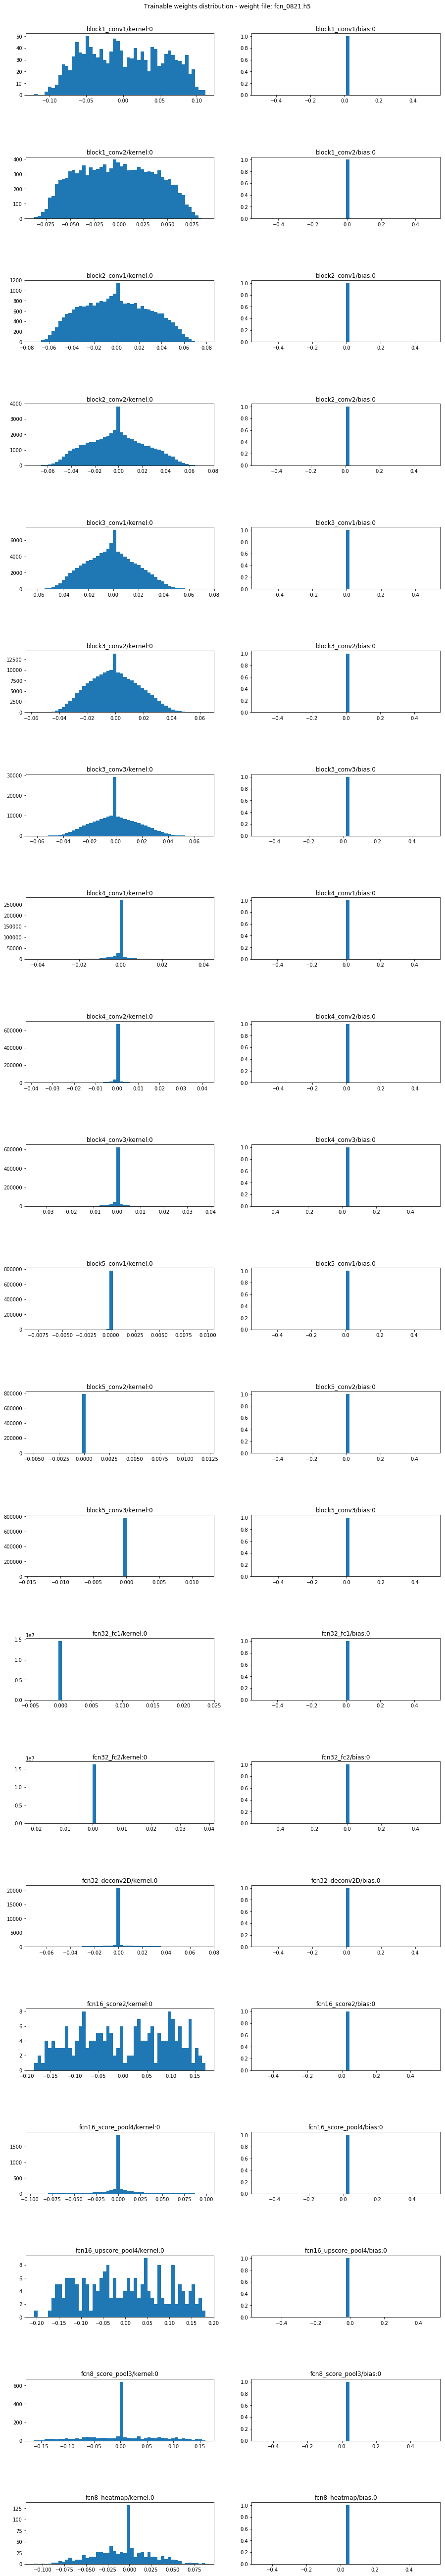

In [8]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[FILE_IDX])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[FILE_IDX]+'.png')
a.savefig(weights_histogram)

## Load Weights - 2nd weight file

In [9]:
FILE_IDX = 11

weights_path = os.path.join(DIR_WEIGHTS  , files[FILE_IDX])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0940.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0940.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0940.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_0940.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [10]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[FILE_IDX]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 7, 64)",-0.1241792589,+0.1135917753,+0.0529531725
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0243982971,+0.0224305447,+0.0092539852
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0920403674,+0.0901497975,+0.0377195999
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0169185828,+0.0120046400,+0.0068737543
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0769483298,+0.0931993201,+0.0290678963
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0113019245,+0.0223073009,+0.0060721543
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0731508210,+0.0739613846,+0.0237059072
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0209878068,+0.0163584277,+0.0070524290
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0680572391,+0.0772938132,+0.0196316447
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0193986781,+0.0295987092,+0.0102481712


### Histograms of Weights - 2nd weights file

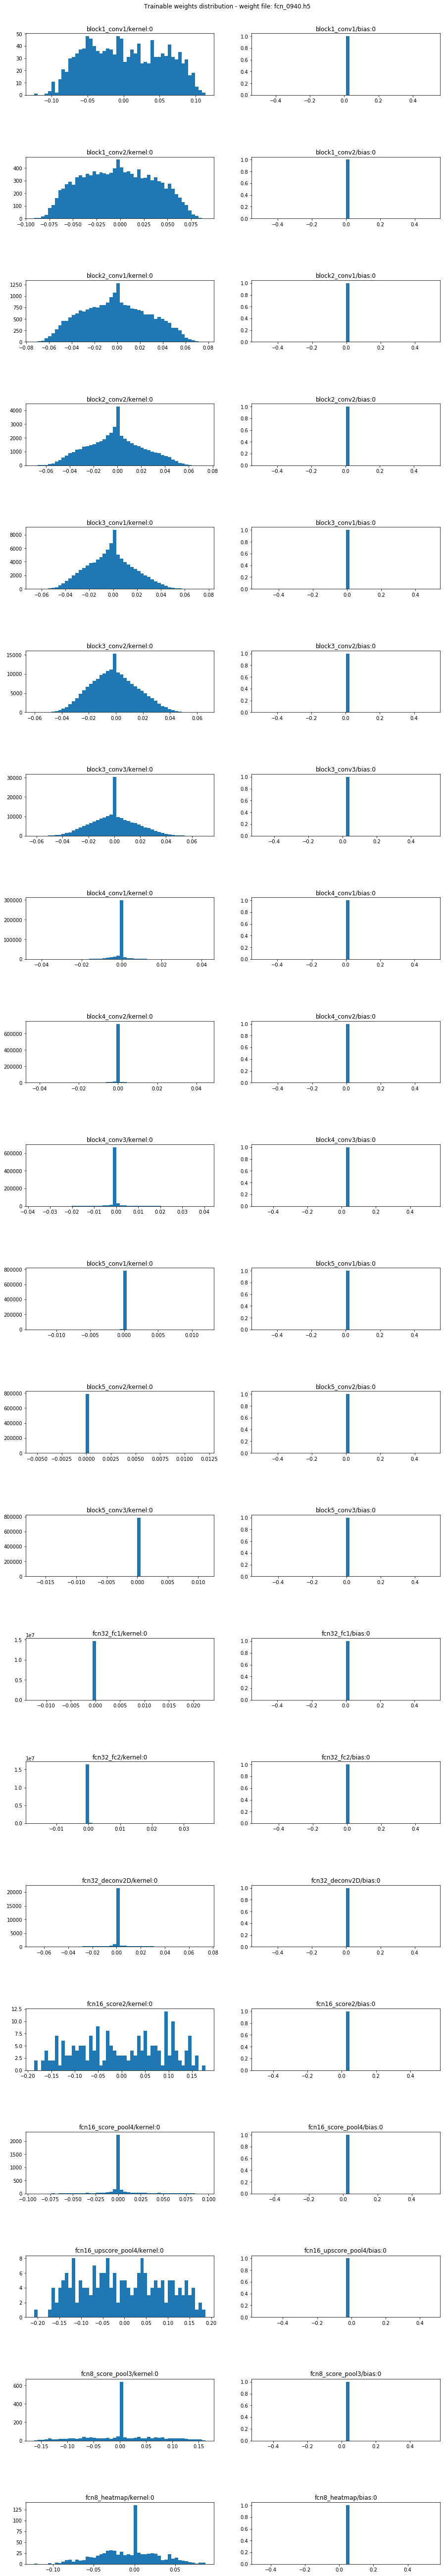

In [11]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[FILE_IDX])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[FILE_IDX]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [24]:
FILE_IDX = 18

weights_path = os.path.join(DIR_WEIGHTS  , files[FILE_IDX])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_2084.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_2084.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_2084.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000\fcn_2084.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 7, 64)",-0.1473224759,+0.1126275361,+0.0516578145
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0337608829,+0.0265375767,+0.0110930959
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1009261459,+0.0940942392,+0.0348355211
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0234073717,+0.0140981451,+0.0082880203
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0855003595,+0.0984097794,+0.0260384213
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0159109719,+0.0254157670,+0.0081888745
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0907478854,+0.0825735182,+0.0208001267
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0320140496,+0.0303125642,+0.0119048106
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0814905241,+0.0830737352,+0.0174563173
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0428492688,+0.0351830497,+0.0134552326


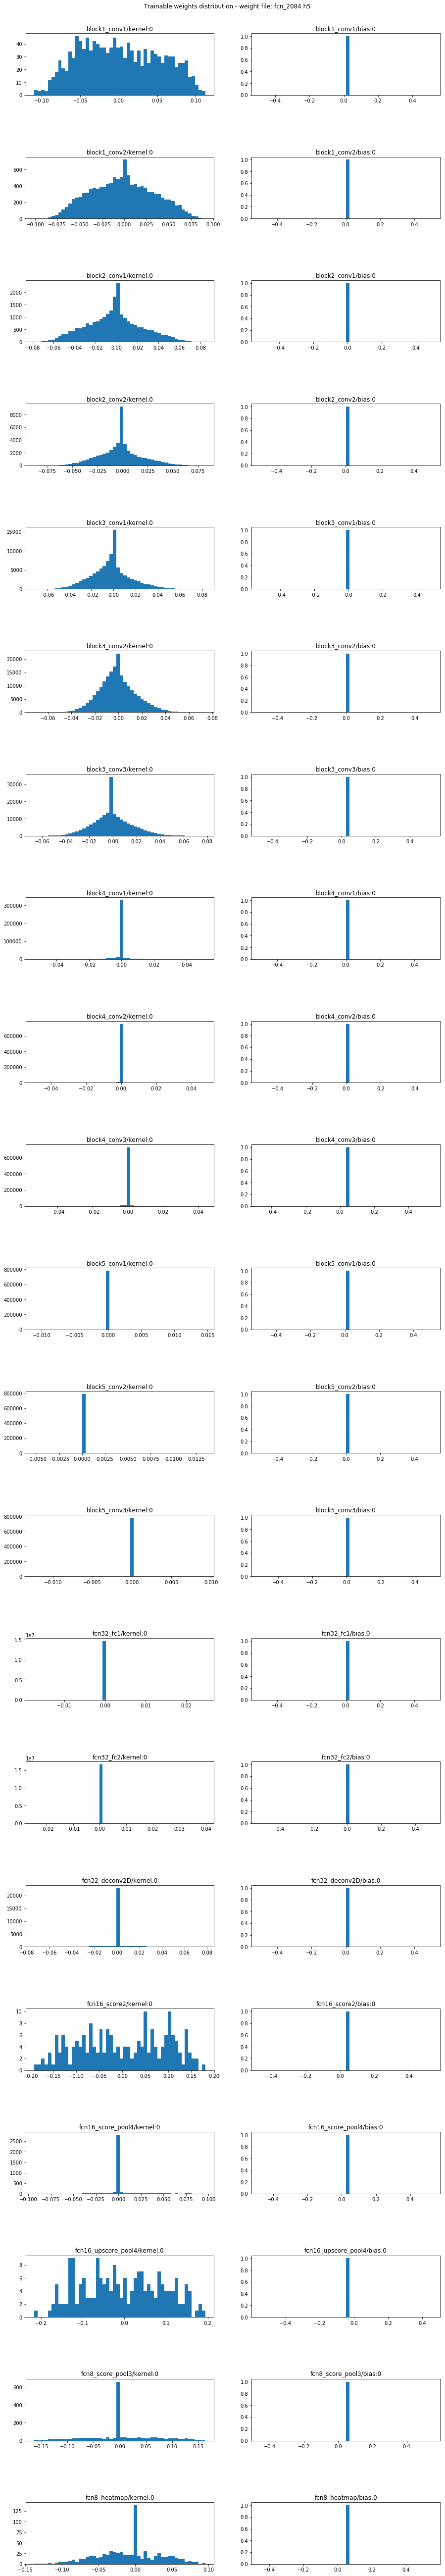

In [25]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[FILE_IDX]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[FILE_IDX])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[FILE_IDX]+'.png')
a.savefig(weights_histogram)

### Histograms of Weights - 3rd weight file

In [13]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[2])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
# a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [20]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0022.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0022.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0022.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0022.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [25]:
# Show stats of all trainable weights    
# _ = visualize.display_weight_stats(fcn_model)

### Histograms of Weights

In [14]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[3])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
# a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [23]:
print(len(files))
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

7
-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0033.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0033.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0033.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [26]:
# Show stats of all trainable weights    
# visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 5th weight file

In [15]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[4])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
# a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [26]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0041.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0041.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0041.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 6th weight file

In [27]:
# Show stats of all trainable weights    
# _ = visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 6th weight file

In [16]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[5])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
# a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [29]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0056.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0056.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0056.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 7th weight file

In [28]:
# Show stats of all trainable weights    
# _ = visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 7th weight file

In [17]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[6])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
# a.savefig(weights_histogram)

## Load Weights - 8th weight file

In [33]:
weights_path = os.path.join(DIR_WEIGHTS  , files[7])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0063.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0063.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0063.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 8th weight file

In [29]:
# Show stats of all trainable weights    
# _ = visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 8th weight file

In [18]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[7])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[7]+'.png')
# a.savefig(weights_histogram)

## Load Weights - 9th weight file

In [36]:
weights_path = os.path.join(DIR_WEIGHTS  , files[8])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0081.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0081.h5
    Weights file loaded: F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T1746\fcn_0081.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 9th weight file

In [30]:
# Show stats of all trainable weights    
# _ = visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 9th weight file

In [19]:
# a = visualize.display_weight_histograms(fcn_model, filename = files[8])
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[8]+'.png')
# a.savefig(weights_histogram)